# Overview

In this project, we use an Alternating Least Squares (ALS) algorithm with Spark APIs to predict the ratings for the movies in [ml-latest-small dataset](https://grouplens.org/datasets/movielens/latest/)

This part will focus on collaborative filtering and use Alternating Least Squares (ALS) algorithm to make movie predictions.


## Alternating Least Squares
ALS is one of the low rank matrix approximation algorithms for collaborative filtering. ALS decomposes user-item matrix into two low rank matrixes: user matrix and item matrix. In collaborative filtering, users and products are described by a small set of latent factors that can be used to predict missing entries. And ALS algorithm learns these latent factors by matrix factorization

The data are contained in the files `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`.


## Prerequiste
None


## Content
1. Load Data
2. Spark ALS based approach for training model
4. ALS Model Selection and Evaluation
5. Model testing
6. Make movie recommendation

In [ ]:
import os
import time

# spark imports
!apt-get -y install openjdk-8-jre-headless
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.mllib.recommendation import ALS

# data science imports
import math
import numpy as np
import pandas as pd

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# spark config
spark = SparkSession \
    .builder \
    .appName("movie recommendation") \
    .config("spark.driver.maxResultSize", "96g") \
    .config("spark.driver.memory", "96g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.master", "local[12]") \
    .getOrCreate()
# get spark context
sc = spark.sparkContext

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)
# for google colab
# copy all files from "ml-100K" directory in Google drive to current directory
!cp -r ./gdrive/MyDrive/movie_recommender/ml-dataset/ml-100K/* .

Mounted at /content/gdrive


## Load Data

In [4]:
!ls

gdrive	links.csv  movies.csv  ratings.csv  README.txt	sample_data  tags.csv


In [5]:
# Has header
movies = spark.read.load('movies.csv', format='csv', header=True, inferSchema=True)
ratings = spark.read.load('ratings.csv', format='csv', header=True, inferSchema=True)
links = spark.read.load('links.csv', format='csv', header=True, inferSchema=True)
tags = spark.read.load('tags.csv', format='csv', header=True, inferSchema=True)

### basic inspection

In [7]:
movies_cnt = movies.count()
movies.show(3)
print('There are total {} movies in the dataset'.format(movies_cnt))

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
+-------+--------------------+--------------------+
only showing top 3 rows

There are total 9742 movies in the dataset


In [8]:
ratings_cnt = ratings.count()
ratings.show(3)
print('There are total {} ratings in the dataset'.format(ratings_cnt))

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
+------+-------+------+---------+
only showing top 3 rows

There are total 100836 ratings in the dataset


In [9]:
links_cnt = links.count()
links.show(3)
print('There are total {} links in the dataset'.format(links_cnt))

+-------+------+------+
|movieId|imdbId|tmdbId|
+-------+------+------+
|      1|114709|   862|
|      2|113497|  8844|
|      3|113228| 15602|
+-------+------+------+
only showing top 3 rows

There are total 9742 links in the dataset


In [10]:
tags_cnt = tags.count()
tags.show(3)
print('There are total {} tags in the dataset'.format(tags_cnt))

+------+-------+---------------+----------+
|userId|movieId|            tag| timestamp|
+------+-------+---------------+----------+
|     2|  60756|          funny|1445714994|
|     2|  60756|Highly quotable|1445714996|
|     2|  60756|   will ferrell|1445714992|
+------+-------+---------------+----------+
only showing top 3 rows

There are total 3683 tags in the dataset


## Below are some observations

What are the ratings?

In [11]:
print('Distinct values of ratings:')
print(sorted(ratings.select('rating').distinct().rdd.map(lambda r: r[0]).collect()))

Distinct values of ratings:
[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


What is minimum number of ratings per user and minimum number of ratings per movie?

In [12]:
tmp1 = ratings.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1


How many movies are rated by only one user?

In [13]:
tmp1 = sum(ratings.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

3446 out of 9724 movies are rated by only one user


What is the total number of users in the data sets?

In [15]:
tmp = ratings.select('userID').distinct().count()
print('We have a total of {} distinct users in the data sets'.format(tmp))

We have a total of 610 distinct users in the data sets


What is the total number of movies in the data sets?

In [16]:
tmp = movies.select('movieID').distinct().count()
print('We have a total of {} distinct movies in the data sets'.format(tmp))

We have a total of 9742 distinct movies in the data sets


How many movies are rated by users? List movies not rated yet?

In [17]:
tmp1 = movies.select('movieID').distinct().count()
tmp2 = ratings.select('movieID').distinct().count()
print('We have a total of {} distinct movies that are rated by users in ratings table'.format(tmp2))
print('We have {} movies that are not rated yet'.format(tmp1-tmp2))

We have a total of 9724 distinct movies that are rated by users in ratings table
We have 18 movies that are not rated yet


List all movie genres

In [19]:
splitter = UserDefinedFunction(lambda x: x.split('|'), ArrayType(StringType()))
print('All distinct genres: ')
movies.select(explode(splitter("genres")).alias("genres")).distinct().show()

All distinct genres: 
+------------------+
|            genres|
+------------------+
|             Crime|
|           Romance|
|          Thriller|
|         Adventure|
|             Drama|
|               War|
|       Documentary|
|           Fantasy|
|           Mystery|
|           Musical|
|         Animation|
|         Film-Noir|
|(no genres listed)|
|              IMAX|
|            Horror|
|           Western|
|            Comedy|
|          Children|
|            Action|
|            Sci-Fi|
+------------------+



Find out the number of movies for each category

In [20]:
print('Counts of movies per genre')
movies.select('movieID', explode(splitter("genres")).alias("genres")) \
    .groupby('genres') \
    .count() \
    .sort(desc('count')) \
    .show()

Counts of movies per genre
+------------------+-----+
|            genres|count|
+------------------+-----+
|             Drama| 4361|
|            Comedy| 3756|
|          Thriller| 1894|
|            Action| 1828|
|           Romance| 1596|
|         Adventure| 1263|
|             Crime| 1199|
|            Sci-Fi|  980|
|            Horror|  978|
|           Fantasy|  779|
|          Children|  664|
|         Animation|  611|
|           Mystery|  573|
|       Documentary|  440|
|               War|  382|
|           Musical|  334|
|           Western|  167|
|              IMAX|  158|
|         Film-Noir|   87|
|(no genres listed)|   34|
+------------------+-----+



## Spark ALS based approach for training model
1. Reload data
2. Split data into train, validation, test
3. ALS model selection and evaluation
4. Model testing

### Reload data
We  use an RDD-based API from pyspark.mllib to predict the ratings, so let's reload "ratings.csv" using sc.textFile and then convert it to the form of (user, item, rating) tuples.

In [6]:
# load data
movie_rating = sc.textFile('ratings.csv')
# preprocess data -- only need ["userId", "movieId", "rating"]
header = movie_rating.take(1)[0]
rating_data = movie_rating \
    .filter(lambda line: line!=header) \
    .map(lambda line: line.split(",")) \
    .map(lambda tokens: (int(tokens[0]), int(tokens[1]), float(tokens[2]))) \
    .cache()
# check three rows
rating_data.take(3)

[(1, 1, 4.0), (1, 3, 4.0), (1, 6, 4.0)]

### Split data
Now we split the data into training/validation/testing sets using a 6/2/2 ratio.

In [7]:
train, validation, test = rating_data.randomSplit([6, 2, 2], seed=99)
# cache data
train.cache()
validation.cache()
test.cache()

PythonRDD[47] at RDD at PythonRDD.scala:53

### ALS model selection and evaluation
With the ALS model, we can use a grid search to find the optimal hyperparameters.

## **The optimal hyperparameters is `{'iterations': 10, 'rank': 12, 'lambda_': 0.2}, `**

In [8]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # train ALS model
            model = ALS.train(
                ratings=train_data,    # (userID, productID, rating) tuple
                iterations=num_iters,
                rank=rank,
                lambda_=reg,           # regularization param
                seed=99)
            # make prediction
            valid_data = validation_data.map(lambda p: (p[0], p[1]))
            predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
            # get the rating result
            ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
            # get the RMSE
            MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
            error = math.sqrt(MSE)
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [9]:
# hyper-param config
num_iterations = 10
ranks = [6, 8, 10, 12, 14, 16]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

6 latent factors and regularization = 0.001: validation RMSE is 1.2670745312235188
6 latent factors and regularization = 0.01: validation RMSE is 1.1128698660744991
6 latent factors and regularization = 0.05: validation RMSE is 0.9686149354417314
6 latent factors and regularization = 0.1: validation RMSE is 0.9079003122236483
6 latent factors and regularization = 0.2: validation RMSE is 0.891914916679658
8 latent factors and regularization = 0.001: validation RMSE is 1.3802413997867324
8 latent factors and regularization = 0.01: validation RMSE is 1.152578176578154
8 latent factors and regularization = 0.05: validation RMSE is 0.9793029286610739
8 latent factors and regularization = 0.1: validation RMSE is 0.9107684353777492
8 latent factors and regularization = 0.2: validation RMSE is 0.8921656975142683
10 latent factors and regularization = 0.001: validation RMSE is 1.437091889549461
10 latent factors and regularization = 0.01: validation RMSE is 1.192478289977215
10 latent factors a

### ALS model learning curve
As we increase number of iterations in training ALS, we can see how RMSE changes and whether or not model is overfitted.

In [10]:
def plot_learning_curve(arr_iters, train_data, validation_data, reg, rank):
    """
    Plot function to show learning curve of ALS
    """
    errors = []
    for num_iters in arr_iters:
        # train ALS model
        model = ALS.train(
            ratings=train_data,    # (userID, productID, rating) tuple
            iterations=num_iters,
            rank=rank,
            lambda_=reg,           # regularization param
            seed=99)
        # make prediction
        valid_data = validation_data.map(lambda p: (p[0], p[1]))
        predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
        # get the rating result
        ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
        # get the RMSE
        MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
        error = math.sqrt(MSE)
        # add to errors
        errors.append(error)

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors)
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()

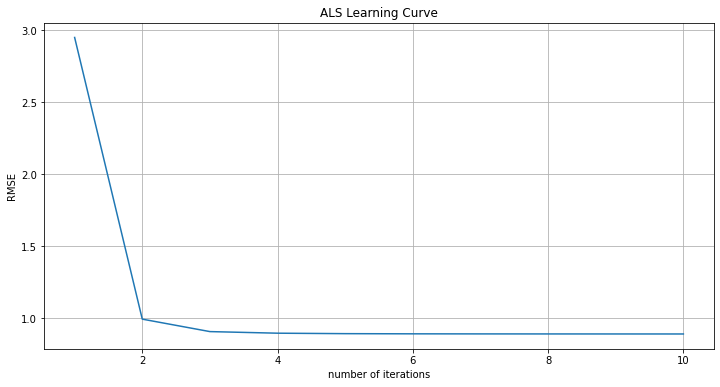

In [11]:
# create an array of num_iters
iter_array = list(range(1, 11))
# create learning curve plot
plot_learning_curve(iter_array, train, validation, 0.2, 12)

After 3 iterations, alternating gradient descend starts to converge at an error around 0.9

### Model testing
And finally, make a prediction and check the testing error using out-of-sample data

In [12]:
# make prediction using test data
test_data = test.map(lambda p: (p[0], p[1]))
predictions = final_model.predictAll(test_data).map(lambda r: ((r[0], r[1]), r[2]))
# get the rating result
ratesAndPreds = test.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
# get the RMSE
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
error = math.sqrt(MSE)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.9006


### Make movie recommendation
Define a function that takes new user's favorite movie and output top 10 recommendations

In [13]:
def get_movieId(df_movies, fav_movie_list):
    """
    return all movieIds of user's favorite movies
    
    Parameters
    ----------
    df_movies: spark Dataframe, movies data
    
    fav_movie_list: list, user's list of favorite movies
    
    Return
    ------
    movieId_list: list of movieIds
    """
    movieId_list = []
    for movie in fav_movie_list:
        movieIds = df_movies \
            .filter(movies.title.like('%{}%'.format(movie))) \
            .select('movieId') \
            .rdd \
            .map(lambda r: r[0]) \
            .collect()
        movieId_list.extend(movieIds)
    return list(set(movieId_list))


def add_new_user_to_data(train_data, movieId_list, spark_context):
    """
    add new rows with new user, user's movie and ratings to
    existing train data

    Parameters
    ----------
    train_data: spark RDD, ratings data
    
    movieId_list: list, list of movieId(s)

    spark_context: Spark Context object
    
    Return
    ------
    new train data with the new user's rows
    """
    # get new user id
    new_id = train_data.map(lambda r: r[0]).max() + 1
    # get max rating
    max_rating = train_data.map(lambda r: r[2]).max()
    # create new user rdd
    user_rows = [(new_id, movieId, max_rating) for movieId in movieId_list]
    new_rdd = spark_context.parallelize(user_rows)
    # return new train data
    return train_data.union(new_rdd)


def get_inference_data(train_data, df_movies, movieId_list):
    """
    return a rdd with the userid and all movies (except ones in movieId_list)

    Parameters
    ----------
    train_data: spark RDD, ratings data

    df_movies: spark Dataframe, movies data
    
    movieId_list: list, list of movieId(s)

    Return
    ------
    inference data: Spark RDD
    """
    # get new user id
    new_id = train_data.map(lambda r: r[0]).max() + 1
    # return inference rdd
    return df_movies.rdd \
        .map(lambda r: r[0]) \
        .distinct() \
        .filter(lambda x: x not in movieId_list) \
        .map(lambda x: (new_id, x))


def make_recommendation(best_model_params, ratings_data, df_movies, 
                        fav_movie_list, n_recommendations, spark_context):
    """
    return top n movie recommendation based on user's input list of favorite movies


    Parameters
    ----------
    best_model_params: dict, {'iterations': iter, 'rank': rank, 'lambda_': reg}

    ratings_data: spark RDD, ratings data

    df_movies: spark Dataframe, movies data

    fav_movie_list: list, user's list of favorite movies

    n_recommendations: int, top n recommendations

    spark_context: Spark Context object

    Return
    ------
    list of top n movie recommendations
    """
    # modify train data by adding new user's rows
    movieId_list = get_movieId(df_movies, fav_movie_list)
    train_data = add_new_user_to_data(ratings_data, movieId_list, spark_context)
    
    # train best ALS
    model = ALS.train(
        ratings=train_data,
        iterations=best_model_params.get('iterations', None),
        rank=best_model_params.get('rank', None),
        lambda_=best_model_params.get('lambda_', None),
        seed=99)
    
    # get inference rdd
    inference_rdd = get_inference_data(ratings_data, df_movies, movieId_list)
    
    # inference
    predictions = model.predictAll(inference_rdd).map(lambda r: (r[1], r[2]))
    
    # get top n movieId
    topn_rows = predictions.sortBy(lambda r: r[1], ascending=False).take(n_recommendations)
    topn_ids = [r[0] for r in topn_rows]
    
    # return movie titles
    return df_movies.filter(movies.movieId.isin(topn_ids)) \
                    .select('title') \
                    .rdd \
                    .map(lambda r: r[0]) \
                    .collect()

## Recommend Movie based on the favorite movie list

In [15]:
# my favorite movies
my_favorite_movies = ['Iron Man','Toy Story']

# get recommends
recommends = make_recommendation(
    best_model_params={'iterations': 10, 'rank': 12, 'lambda_': 0.2}, 
    ratings_data=rating_data, 
    df_movies=movies, 
    fav_movie_list=my_favorite_movies, 
    n_recommendations=10, 
    spark_context=sc)

print('Recommendations for {}:'.format(my_favorite_movies))
for i, title in enumerate(recommends):
    print('{0}: {1}'.format(i+1, title))

Recommendations for Iron Man:
1: Babes in Toyland (1934)
2: On the Beach (1959)
3: Son of the Bride (Hijo de la novia, El) (2001)
4: Mr. Skeffington (1944)
5: Saving Face (2004)
6: Strictly Sexual (2008)
7: 12 Angry Men (1997)
8: Dylan Moran: Monster (2004)
9: Very Potter Sequel, A (2010)
10: Bill Hicks: Revelations (1993)
